# <span style="color: black;"><center>Diplomado de Inteligencia Artificial y Aprendizaje Profundo</center></span>

# <span style="color: purple;"><center>Colorizador de imagenes</center></span>

## <span style="color: black;">Presentado por:</span>

## <span style="color: purple;">Andrés Felipe Nieto Grandas</span>

### <span style="color: purple;">Introducción</span>

**<p>En este cuaderno me propongo a ilustrar el proceso de preparacion de datos, modelamiento y entrenamiento de una maquina capaz de darle color a imagenes que esten en escala de grises.</p>**

### <span style="color: purple;">Importamos las librerias</span>

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import keras
import cv2
import os
from tqdm import tqdm
import re
import matplotlib.pyplot as plt
import tarfile

from keras import backend as K
# importar layers apropiados para la Red
from tensorflow.keras.layers import Input, Dense, Activation, Flatten, Reshape, Conv2D, Conv2DTranspose
from tensorflow.keras.models import Model
# Graficar modelo
from tensorflow.keras.utils import plot_model
# Importar optimizadores
from tensorflow.keras.optimizers import Adam, Adamax
# Importar Función de Pérdida
from tensorflow.keras.losses import MeanSquaredError
# Función parar separar datos de entrenamiento y validación
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint 

### <span style="color: purple;">Descargamos los datasets requeridos para el modelo</span>

In [2]:
!wget --no-check-certificate \
  http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz \
  -O /tmp/lfw-deepfunneled.tgz

!wget --no-check-certificate \
  http://www.cs.columbia.edu/CAVE/databases/pubfig/download/lfw_attributes.txt \
  -O /tmp/lfw_attributes.txt

!wget --no-check-certificate \
  http://vis-www.cs.umass.edu/lfw/lfw.tgz \
  -O /tmp/lfw.tgz
  

--2021-05-30 21:22:38--  http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz
Resolving vis-www.cs.umass.edu (vis-www.cs.umass.edu)... 128.119.244.95
Connecting to vis-www.cs.umass.edu (vis-www.cs.umass.edu)|128.119.244.95|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 108761145 (104M) [application/x-gzip]
Saving to: ‘/tmp/lfw-deepfunneled.tgz’

/tmp/lfw-deepfunnel 100%[===================>] 103.72M  33.2MB/s    in 3.3s    

2021-05-30 21:22:42 (31.7 MB/s) - ‘/tmp/lfw-deepfunneled.tgz’ saved [108761145/108761145]

--2021-05-30 21:22:42--  http://www.cs.columbia.edu/CAVE/databases/pubfig/download/lfw_attributes.txt
Resolving www.cs.columbia.edu (www.cs.columbia.edu)... 128.59.11.206
Connecting to www.cs.columbia.edu (www.cs.columbia.edu)|128.59.11.206|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www.cs.columbia.edu/CAVE/databases/pubfig/download/lfw_attributes.txt [following]
--2021-05-30 21:22:42--  https://

### <span style="color: purple;">Asignamos variables con las rutas de los archivos</span>

In [3]:
ATTRS_NAME = '/tmp/lfw_attributes.txt'
IMAGES_NAME = '/tmp/lfw-deepfunneled.tgz'
RAW_IMAGES_NAME = '/tmp/lfw.tgz'

### <span style="color: purple;">Función  para decodificar las imágenes bajadas desde datos crudos (bytes)</span>

In [4]:
def decode_image_from_raw_bytes(raw_bytes):
    # Decodificar desde archivos crudos en formato adecuado, flag =1 significa leer en BGR
    img = cv2.imdecode(np.asarray(bytearray(raw_bytes), dtype=np.uint8), 1)
    #Convertir a RGB
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

### <span style="color: purple;">Extraccion de una imagen y su forma</span>

In [5]:
indice=30
#indice=slice(3)

with tarfile.open(RAW_IMAGES_NAME) as f:
    m=f.getmembers()[indice]
    print(m)
    img=decode_image_from_raw_bytes(f.extractfile(m).read())
    print(img.shape)

<TarInfo 'lfw/Michael_Schumacher/Michael_Schumacher_0008.jpg' at 0x7f9d07cf5530>
(250, 250, 3)


### <span style="color: purple;">Función que se encanga de preparar las imagenes sin descomprimir los archivos</span>

In [6]:
def load_lfw_dataset(
        use_raw=False,
        dx=45, dy=45,
        dimx=45, dimy=45):

    # Leer archivo lfw_attributes.txt y hacer una limpieza inicial
    df_attrs = pd.read_csv(ATTRS_NAME, sep='\t', skiprows=1)
    # Corrimiento de carácteres incorrectos
    df_attrs = pd.DataFrame(df_attrs.iloc[:, :-1].values, columns=df_attrs.columns[1:])
    # Filtrar nombres de personas y numeros de imagen (por persona), convertir a conjunto
    imgs_with_attrs = set(map(tuple, df_attrs[["person", "imagenum"]].values))

    # Leer Fotos e identificación
    all_photos = []
    photo_ids = []

    # Abrir archivo .tgz sin descomprimir
    with tarfile.open(RAW_IMAGES_NAME if use_raw else IMAGES_NAME) as f:
        # tqdm se usa para mostrar la barra de progreso
        for m in tqdm(f.getmembers()):
            # Solo procesa los archivos desde el archivo comprimido que sean realmente imágenes (.jpg)
            if m.isfile() and m.name.endswith(".jpg"):
                # Descomprimir archivo desde el comprimido y convertir a RGB
                img = decode_image_from_raw_bytes(f.extractfile(m).read())

                # Recortar lo que sean caras y cambiar tamaño
                img = img[dy:-dy, dx:-dx]
                img = cv2.resize(img, (dimx, dimy))

                # Obtener nombre de la persona y agregarlo a la colección de datos
                fname = os.path.split(m.name)[-1]
                # La razón de -4 es para quitar la extensión .jpg
                fname_splitted = fname[:-4].replace('_', ' ').split()
                # Sacar la identificación del nombre
                person_id = ' '.join(fname_splitted[:-1])
                # Sacar el número de foto por separado
                photo_number = int(fname_splitted[-1])
                # Comparar los metadatos con las fotos reales (DEBEN COINCIDIR)
                if (person_id, photo_number) in imgs_with_attrs:
                    # Cuando coinciden, agregar las fotos
                    all_photos.append(img)
                    # Y también agregar la identidad de las personas
                    photo_ids.append({'person': person_id, 'imagenum': photo_number})
                    
    # Hacer un dataframe con los resultados
    photo_ids = pd.DataFrame(photo_ids)
    # UNir las imágenes en un tensor 4D
    all_photos = np.stack(all_photos).astype('uint8')

    # Preservar el orden de encontrados en búsqueda
    all_attrs = photo_ids.merge(df_attrs, on=('person', 'imagenum')).drop(["person", "imagenum"], axis=1)

    return all_photos, all_attrs, photo_ids

### <span style="color: purple;">Obtenemos los datos del conjunto</span>

In [7]:
dim_x=80
dim_y=80
X, attr,names = load_lfw_dataset(use_raw=True, dimx=dim_x, dimy=dim_y)

100%|██████████| 18983/18983 [00:13<00:00, 1437.75it/s]


### <span style="color: purple;">Transformamos las imagenes a float y las dividimos en 255</span>

In [8]:
X = X.astype('float32')/255.
X.shape

(13143, 80, 80, 3)

### <span style="color: purple;">Presentamos las imagenes</span>

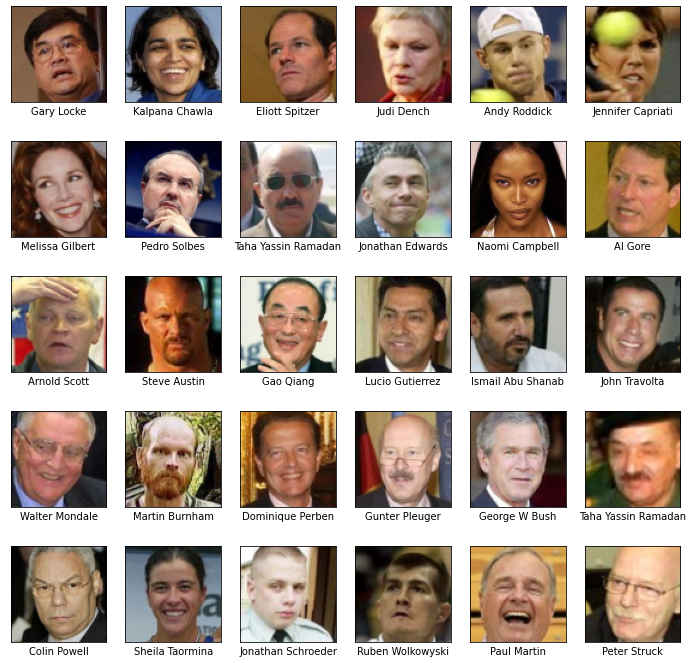

In [9]:
plt.figure(figsize=(12,12))

numero_muestras=30

muestra=np.random.randint(0,len(X),numero_muestras)

for i in range(numero_muestras):
    plt.subplot(5,6,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X[muestra[i]])
    plt.xlabel(names.person[muestra[i]])

plt.show()

### <span style="color: purple;">convertimos el set de datos a escala de grises</span>

In [10]:
X_gray = X[..., :3]@[0.299,0.587,0.114]
print(X_gray.shape)

(13143, 80, 80)


### <span style="color: purple;">Presentamos las imagenes en gris</span>

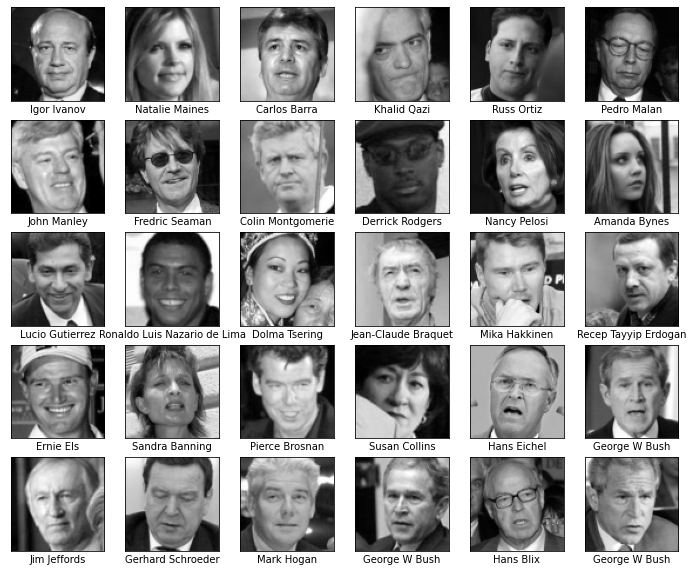

In [11]:
plt.figure(figsize=(12,10))
numero_muestras = 30

muestras=np.random.randint(0,len(X_gray), numero_muestras)

for i in range(numero_muestras):
  plt.subplot(5,6,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(X_gray[muestras[i]], cmap='gray')
  plt.xlabel(names.person[muestras[i]])
plt.show()

### <span style="color: purple;">Agregamos una dimencion a el conjunto de imagenes</span>

In [12]:
X_gray = np.expand_dims(X_gray, axis=3)
print(X_gray.shape)

(13143, 80, 80, 1)


### <span style="color: purple;">Parametrización del entrenamiento</span>

In [13]:
# network parameters
rows = X.shape[1]
cols = X.shape[2]
channels = X.shape[3]

input_shape = (rows, cols, 1)
batch_size = 256
kernel_size = 2
latent_dim = 256
epochs = 20

layer_filters = [64, 128, 256] 

## <span style="color: purple;">Encoder</span>

In [14]:
inputs = Input(shape=input_shape, name='encoder_input')
x = inputs
# stack of Conv2D(32)-Conv2D(64)
for filters in layer_filters:
  x = Conv2D(filters=filters,
             kernel_size=kernel_size,
             strides=2,
             activation='relu',
             padding='same')(x)

shape = K.int_shape(x)

# generate the latent vector
x = Flatten()(x)
latent = Dense(latent_dim, name='latent_vector')(x)
encoder_color = Model(inputs, latent, name='encoder_color')

In [15]:
shape

(None, 10, 10, 256)

Model: "encoder_color"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, 80, 80, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 40, 40, 64)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 20, 20, 128)       32896     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 10, 256)       131328    
_________________________________________________________________
flatten (Flatten)            (None, 25600)             0         
_________________________________________________________________
latent_vector (Dense)        (None, 256)               6553856   
Total params: 6,718,400
Trainable params: 6,718,400
Non-trainable params: 0
___________________________________________

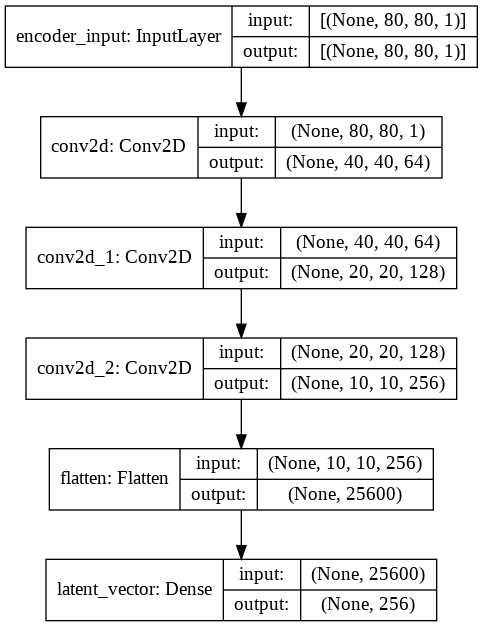

In [16]:
encoder_color.summary()
plot_model(encoder_color, to_file='encoder_conv_lfw.png', show_shapes=True)

## <span style="color: purple;">Decoder</span>

In [17]:
latent_inputs = Input(shape= (latent_dim,), name = 'decoder_input')
x = Dense(shape[1]*shape[2]*shape[3])(latent_inputs)
x = Reshape((shape[1],shape[2],shape[3]))(x)
#Deconvolución  
for filters in layer_filters[::-1]:
  x = Conv2DTranspose(filters=filters,
                      kernel_size = kernel_size,
                      strides = 2,
                      activation = 'relu',
                      padding = 'same')(x)

outputs = Conv2DTranspose(filters=channels,
                          kernel_size=2,
                          activation = 'sigmoid',
                          padding = 'same',
                          
                          name =  'decoder_output')(x)

decoder_color = Model(latent_inputs, outputs, name = 'decoder_color')

Model: "decoder_color"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   [(None, 256)]             0         
_________________________________________________________________
dense (Dense)                (None, 25600)             6579200   
_________________________________________________________________
reshape (Reshape)            (None, 10, 10, 256)       0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 20, 20, 256)       262400    
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 40, 40, 128)       131200    
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 80, 80, 64)        32832     
_________________________________________________________________
decoder_output (Conv2DTransp (None, 80, 80, 3)       

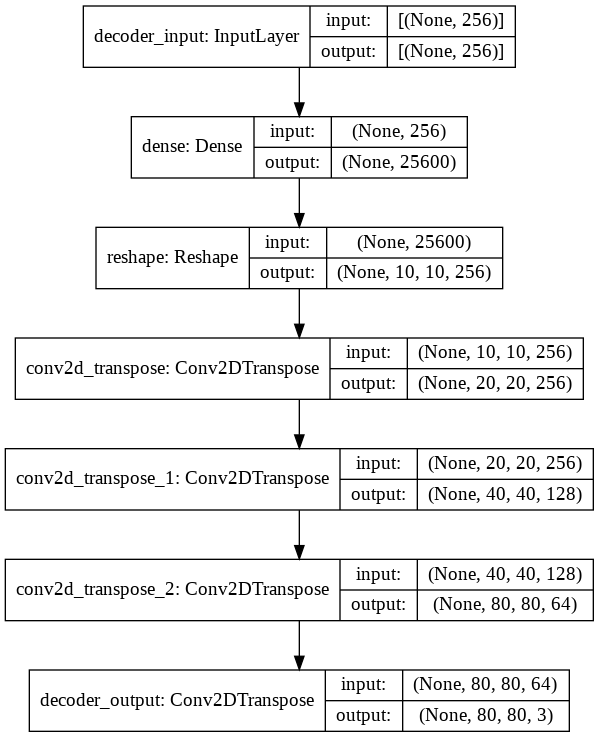

In [18]:
decoder_color.summary()

plot_model(decoder_color, to_file='decoder_conv_lfw.png', show_shapes=True)

## <span style="color: purple;">Autoencoder</span>

Model: "autoencoder_color"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, 80, 80, 1)]       0         
_________________________________________________________________
encoder_color (Functional)   (None, 256)               6718400   
_________________________________________________________________
decoder_color (Functional)   (None, 80, 80, 3)         7006403   
Total params: 13,724,803
Trainable params: 13,724,803
Non-trainable params: 0
_________________________________________________________________


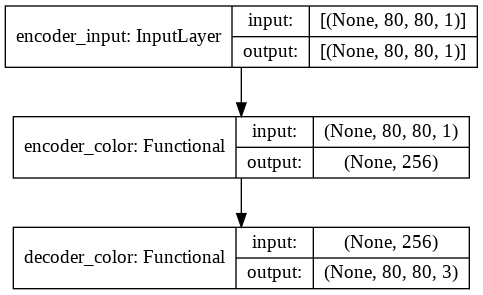

In [19]:
# Autoencoder Model
autoencoder_color = Model(inputs=inputs, 
                    outputs=decoder_color(encoder_color(inputs)),
                    name='autoencoder_color')

#Summary
autoencoder_color.summary()
plot_model(autoencoder_color, to_file='autoencoder_color.png',show_shapes=True)

## <span style="color: purple;">Callback</span>

#### <span style="color: black;">Los callbacks nos permiten ir identificando patrones o errores mientras en modelo se entrena, de esta manera podemos hacer modificaciones y salvando nuestro modelo en diferentes puntos</span>

In [20]:
# prepare model saving directory.
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'colorized_ae_model.{epoch:03d}.h5'
if not os.path.isdir(save_dir):
        os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

# reduce learning rate by sqrt(0.1) if the loss does not improve in 5 epochs
lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               verbose=1,
                               min_lr=0.5e-6)

# save weights for future use (e.g. reload parameters w/o training)
checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_loss',
                             verbose=1,
                             save_best_only=True)


# called every epoch
callbacks = [lr_reducer, checkpoint]

### <span style="color: purple;">Compilador Autoencoder</span>

In [21]:
autoencoder_color.compile(optimizer='adam', loss = 'mse', metrics = ['mae'])

### <span style="color: purple;">Separamos las imagenes a color en dos partes una para entrenamiento y la otra para test</span>

In [22]:
# Separar datos en entrenamiento y validación interna
X_train,X_test=train_test_split(X,test_size=0.2, random_state=42)

### <span style="color: purple;">Separamos las imagenes en gris en dos partes una para entrenamiento y la otra para test</span>

In [23]:
# Separar datos en entrenamiento y validación interna para imagenes a B/N
X_train_gray,X_test_gray=train_test_split(X_gray,test_size=0.2, random_state=42)

### <span style="color: purple;">Importamos libreria que nos permite acceder al google drive</span>

In [25]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
ruta = 'gdrive/My Drive/Colab Notebooks/Reto 1/'

Mounted at /content/gdrive


### <span style="color: purple;">Cargamos nuestro modelo previamente entrenado</span>

In [29]:
history = keras.models.load_model(ruta + 'ColorizadorImg.h5')

### <span style="color: purple;">Entrenamiento del modelo</span>

In [ ]:
history = autoencoder_color.fit(X_train_gray,
                X_train,
                validation_data=(X_test_gray, X_test),
                epochs=epochs,
               batch_size=batch_size,
                callbacks=callbacks)

Epoch 1/20
42/42 [==============================] - 225s 5s/step - loss: 0.0579 - mae: 0.1983 - val_loss: 0.0403 - val_mae: 0.1560

Epoch 00001: val_loss improved from inf to 0.04026, saving model to /content/saved_models/colorized_ae_model.001.h5
Epoch 2/20
42/42 [==============================] - 223s 5s/step - loss: 0.0290 - mae: 0.1309 - val_loss: 0.0234 - val_mae: 0.1150

Epoch 00002: val_loss improved from 0.04026 to 0.02337, saving model to /content/saved_models/colorized_ae_model.002.h5
Epoch 3/20
42/42 [==============================] - 223s 5s/step - loss: 0.0207 - mae: 0.1073 - val_loss: 0.0188 - val_mae: 0.1018

Epoch 00003: val_loss improved from 0.02337 to 0.01885, saving model to /content/saved_models/colorized_ae_model.003.h5
Epoch 4/20
42/42 [==============================] - 223s 5s/step - loss: 0.0170 - mae: 0.0960 - val_loss: 0.0159 - val_mae: 0.0930

Epoch 00004: val_loss improved from 0.01885 to 0.01593, saving model to /content/saved_models/colorized_ae_model.004

### <span style="color: purple;">Guardamos nuestro modelo</span>

In [ ]:
autoencoder_color.save(ruta + 'ColirizadorImg.h5')

### <span style="color: purple;">Grafica que presenta los valores de perdida logrados en el entrenamiento</span>

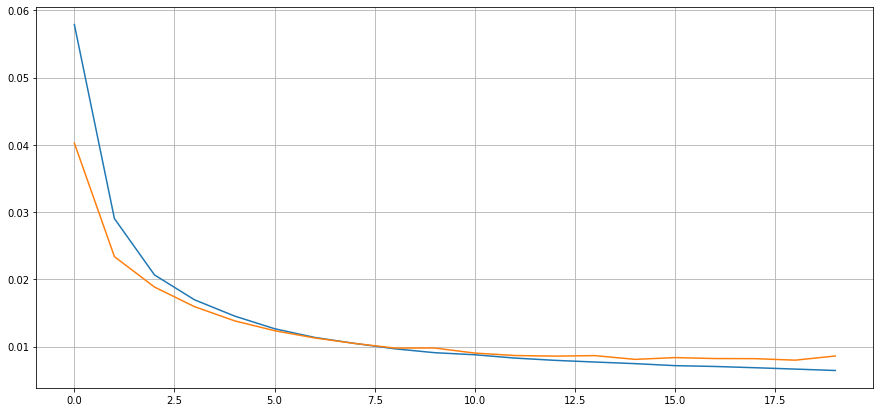

In [ ]:
plt.figure(figsize=(15,7))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.grid()
plt.show()

### <span style="color: purple;">Realizamos las predicciones sobre el conjunto de datos en gris</span>

In [30]:
x_decoded = history.predict(X_gray)

### <span style="color: purple;">Graficamos las predicciones</span>

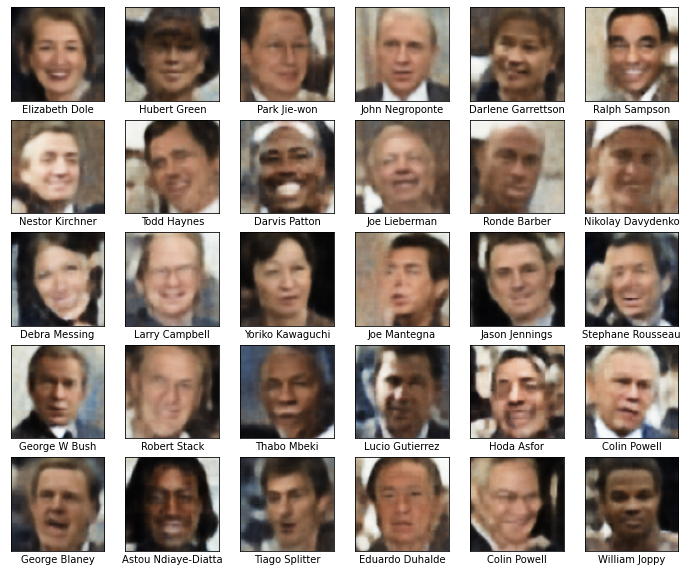

In [31]:
plt.figure(figsize = (12,10))
numero_muestras = 30
muestras = np.random.randint(0, len(x_decoded), numero_muestras)

for i in range(numero_muestras):
  plt.subplot(5,6,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(x_decoded[muestras[i]])
  plt.xlabel(names.person[muestras[i]])
plt.show()

### <span style="color: purple;">Graficamos la diferencia entre los 3 conjuntos de datos</span>

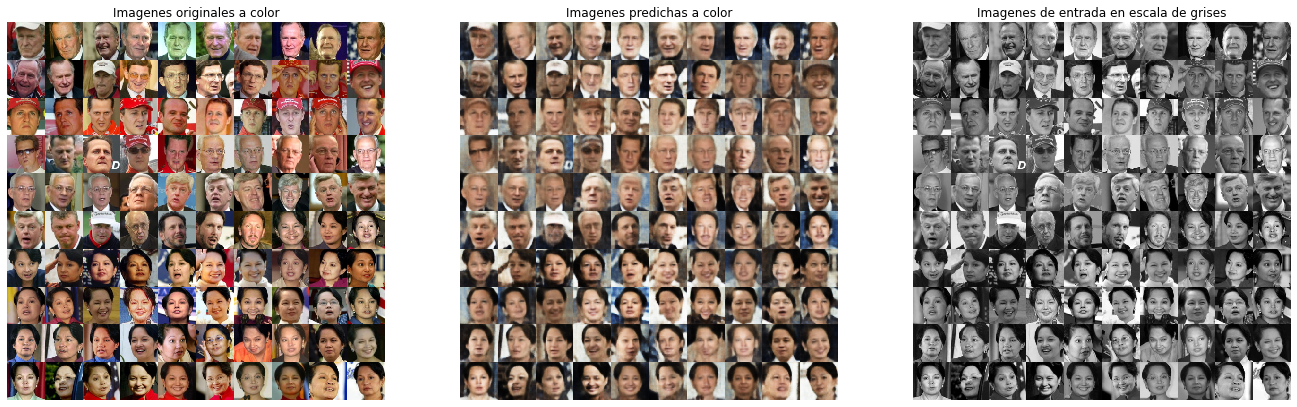

In [32]:
plt.figure(figsize=(23,23))

img_rows = rows
img_cols = cols 

# Imagenes reales
plt.subplot(131)
imgs_t = X[:100]
imgs_t = imgs_t.reshape((10,10, img_rows, img_cols, channels))
imgs_t = np.vstack([np.hstack(i) for i in imgs_t])
#plt.figure(figsize=(10,10))
plt.axis('off')
plt.title('Imagenes originales a color')
plt.imshow(imgs_t, interpolation='none')

# Imagenes PREDICHAS
 
plt.subplot(132)
imgs = x_decoded[:100]
imgs = imgs.reshape((10,10, img_rows, img_cols, channels))
imgs = np.vstack([np.hstack(i) for i in imgs])
#plt.figure(figsize=(10,10))
plt.axis('off')
plt.title('Imagenes predichas a color')
plt.imshow(imgs, interpolation='none')


# Imagenes a B/N 
plt.subplot(133)

imgs_g = X_gray[:100]
imgs_g = imgs_g.reshape((10,10, img_rows, img_cols))
imgs_g = np.vstack([np.hstack(i) for i in imgs_g])
#plt.figure(figsize=(10,10))
plt.axis('off')
plt.title('Imagenes de entrada en escala de grises')
plt.imshow(imgs_g, interpolation='none', cmap='gray')

plt.show()


### <span style="color: purple;">Importamos llibrerias que nos permiten cargar archivos</span>

In [96]:
from PIL import Image 
from google.colab import files
images = files.upload()

Saving Andres.png to Andres.png


### <span style="color: purple;">convertimos la imagen guardada en escala de grises</span>

In [97]:
foto = Image.open('/content/Andres.png')
foto = foto.convert('L')

### <span style="color: purple;">Pintamos la imagen</span>

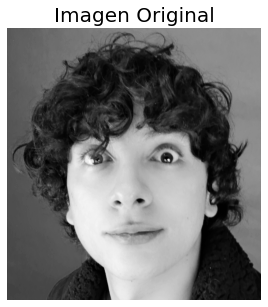

In [110]:
plt.figure(figsize=(5,5))
plt.title('Imagen Original', fontsize = 20)
plt.imshow(foto, cmap='gray')

plt.axis('off')
plt.show()


### <span style="color: purple;">Se transforma la imagen a la forma necesaria</span>

In [104]:
foto_gris = (np.array(foto))/255. 
foto_gris = cv2.resize(foto_gris,(80,80)).flatten()
foto_gris = np.array(foto_gris).reshape(1,80,80,1)
print('Nueva forma de los datos:', foto_gris.shape)

Nueva forma de los datos: (1, 80, 80, 1)


### <span style="color: purple;">Se pasa la imagen por el predictor</span>

In [112]:
Foto_a_color = history.predict(foto_gris)

### <span style="color: purple;">Graficamos la predicción</span>

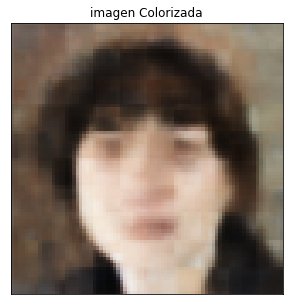

In [116]:
plt.figure(figsize = (5,5))

imgs = Foto_a_color
imgs = imgs.reshape(img_rows, img_cols, channels)
#imgs = np.vstack([np.hstack(i) for i in imgs])
plt.title('imagen Colorizada')
plt.xticks([])
plt.yticks([])
plt.grid(False)
plt.imshow(imgs, interpolation='none')
plt.axis('on')
plt.show()


#### <span style="color: black;">Como se puede observar el modelo esta coloreando nuestra imagen de una manera no muy precisa pero tampoco muy imprecisa, lo que nos da a entender que el trabajo puede llegar a lograr mejores resultados...</span>